<h1 style="color:black;"> Modeling Logistic Regression, Support Vector Machine, and K Nearest Neighbor</h1>

<h2 style="color:black;">1. Define Target Variable and Data Partition</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from imblearn.under_sampling import RandomUnderSampler

df = pd.read_csv('Customer-Churn-Records-Processed-Ordinal-Scaled.csv')

X = df.drop(columns=['Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

<h2 style="color:black;">2. Baseline Logistic Regression</h2>

In [2]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))

feature_importance = pd.DataFrame({"Feature": X_train.columns, "Coefficient": logreg.coef_[0]})
print("Feature Importance:")
print(feature_importance.sort_values(by="Coefficient", ascending=False))

Model Performance:
Accuracy: 0.8203
Precision: 0.6538
Recall: 0.2504
F1 Score: 0.3621
Confusion Matrix:
[[2308   81]
 [ 458  153]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      2389
           1       0.65      0.25      0.36       611

    accuracy                           0.82      3000
   macro avg       0.74      0.61      0.63      3000
weighted avg       0.80      0.82      0.79      3000

Feature Importance:
               Feature  Coefficient
2                  Age     0.815275
12   Geography_Germany     0.810942
1               Gender     0.511732
4              Balance     0.157323
8      EstimatedSalary     0.062114
13     Geography_Spain     0.042211
10           Card Type     0.006127
3               Tenure    -0.015575
9   Satisfaction Score    -0.023182
6            HasCrCard    -0.048293
11        Point Earned    -0.048816
5        NumOfProducts    -0.055959
0          CreditScore    -0.08

<h2 style="color:black;">3. Apply Random Undersampling to balance the dataset</h2>

In [3]:
rus = RandomUnderSampler(random_state=2)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

<h2 style="color:black;">4. Apply Feature Selection using RFE & Tune Logistic Regression</h2>

,Dataset,Model,Accuracy,Precision,Recall,F1 Score,F2 Score
0,Train,Logistic Regression,0.717589,0.720682,0.710582,0.715596,0.712579
1,Test,Logistic Regression,0.750000,0.426455,0.659574,0.517995,0.594571


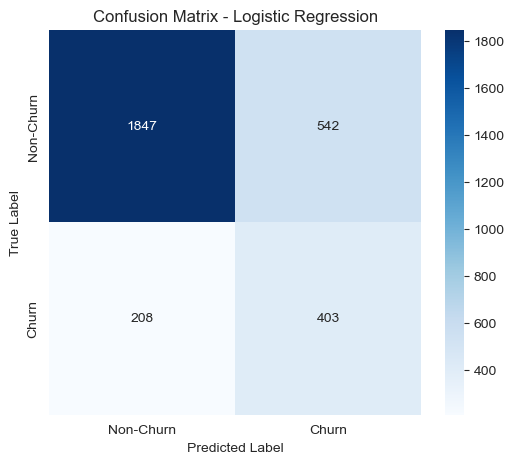

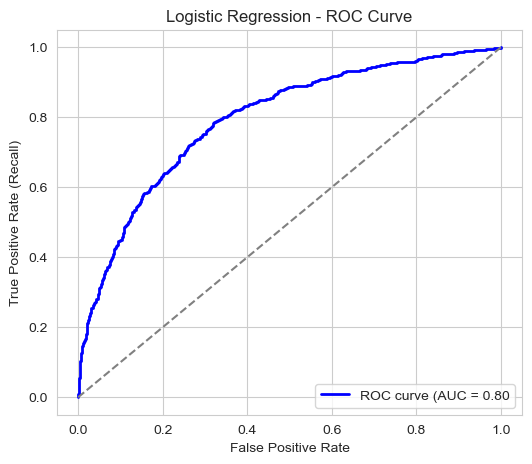

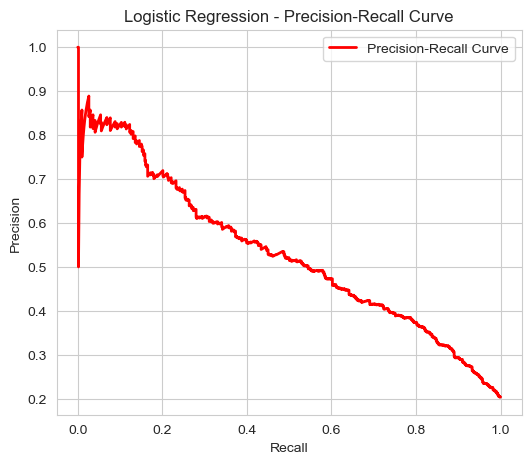

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      2389
           1       0.43      0.66      0.52       611

    accuracy                           0.75      3000
   macro avg       0.66      0.72      0.67      3000
weighted avg       0.80      0.75      0.77      3000


Model results saved to 'model_comparison_results_LogReg_SVM_NN_KNN.csv'


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report

sns.set_style("whitegrid")

results = []

def evaluate_model(model, model_name, X_train, y_train, X_test, y_test, threshold=0.55):
    y_train_pred = model.predict(X_train)
    y_test_prob = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_prob >= threshold).astype(int)
    
    train_metrics = {
        "Dataset": "Train",
        "Model": model_name,
        "Accuracy": accuracy_score(y_train, y_train_pred),
        "Precision": precision_score(y_train, y_train_pred),
        "Recall": recall_score(y_train, y_train_pred),
        "F1 Score": f1_score(y_train, y_train_pred),
        "F2 Score": fbeta_score(y_train, y_train_pred, beta=2)
    }
    
    test_metrics = {
        "Dataset": "Test",
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred),
        "Recall": recall_score(y_test, y_test_pred),
        "F1 Score": f1_score(y_test, y_test_pred),
        "F2 Score": fbeta_score(y_test, y_test_pred, beta=2)
    }
    
    results.extend([train_metrics, test_metrics])
    
    results_df = pd.DataFrame(results)
    display(results_df)
    
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Churn', 'Churn'], yticklabels=['Non-Churn', 'Churn'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"{model_name} - ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
    
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color='red', lw=2, label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} - Precision-Recall Curve")
    plt.legend()
    plt.show()
    
    print("Classification Report:")
    print(classification_report(y_test, y_test_pred))

logreg_rfe = LogisticRegression(class_weight='balanced', max_iter=1000)
selector = RFE(logreg_rfe, n_features_to_select=12)
selector.fit(X_train_resampled, y_train_resampled)
X_train_selected = selector.transform(X_train_resampled)
X_test_selected = selector.transform(X_test)

logreg_model = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), param_grid={'C': [0.01, 0.1, 1]}, cv=5, scoring='f1')
logreg_model.fit(X_train_selected, y_train_resampled)
best_logreg = logreg_model.best_estimator_
evaluate_model(best_logreg, "Logistic Regression", X_train_selected, y_train_resampled, X_test_selected, y_test)

results_df = pd.DataFrame(results)
results_df.to_csv("model_comparison_results_LogReg_SVM_NN_KNN.csv", index=False)
print("\nModel results saved to 'model_comparison_results_LogReg_SVM_NN_KNN.csv'")

<h2 style="color:black;">5. SVM Model

,Dataset,Model,Accuracy,Precision,Recall,F1 Score,F2 Score
0,Train,Logistic Regression,0.717589,0.720682,0.710582,0.715596,0.712579
1,Test,Logistic Regression,0.750000,0.426455,0.659574,0.517995,0.594571
2,Train,SVM,0.801682,0.811280,0.786265,0.798577,0.791144
3,Test,SVM,0.792667,0.494241,0.772504,0.602810,0.694322


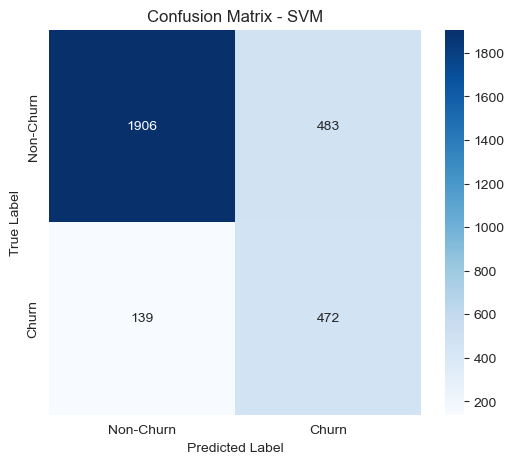

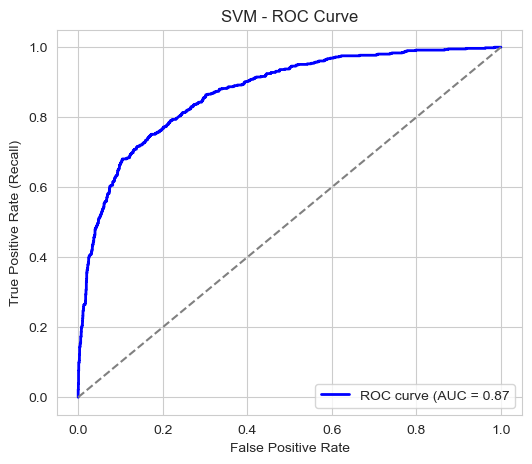

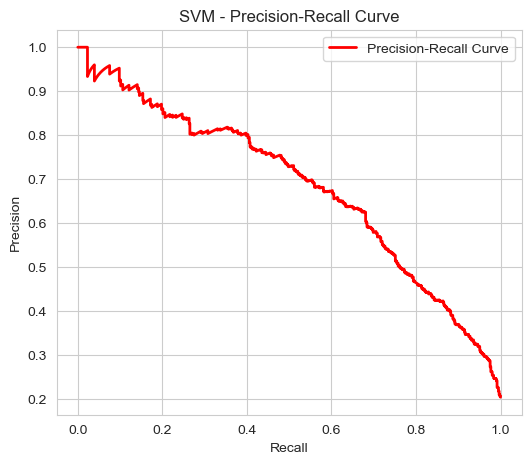

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      2389
           1       0.49      0.77      0.60       611

    accuracy                           0.79      3000
   macro avg       0.71      0.79      0.73      3000
weighted avg       0.84      0.79      0.81      3000


Model results updated and saved to 'model_comparison_results_LogReg_SVM_NN_KNN.csv'


In [5]:
svm_model = GridSearchCV(SVC(probability=True, class_weight='balanced'), param_grid={'C': [0.01, 0.1, 1], 'kernel': ['linear', 'rbf']}, cv=5, scoring='f1')
svm_model.fit(X_train_selected, y_train_resampled)
best_svm = svm_model.best_estimator_
evaluate_model(best_svm, "SVM", X_train_selected, y_train_resampled, X_test_selected, y_test)

results_df = pd.DataFrame(results)
results_df.to_csv("model_comparison_results_LogReg_SVM_NN_KNN.csv", index=False)
print("\nModel results updated and saved to 'model_comparison_results_LogReg_SVM_NN_KNN.csv'")

<h2 style="color:black;">6. Neural Network</h2>

C:\Users\colby\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\colby\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\colby\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\colby\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\colby\anaconda3\Lib\site-packages\sklearn\neural_network\_m

,Dataset,Model,Accuracy,Precision,Recall,F1 Score,F2 Score
0,Train,Logistic Regression,0.717589,0.720682,0.710582,0.715596,0.712579
1,Test,Logistic Regression,0.750000,0.426455,0.659574,0.517995,0.594571
2,Train,SVM,0.801682,0.811280,0.786265,0.798577,0.791144
3,Test,SVM,0.792667,0.494241,0.772504,0.602810,0.694322
4,Train,Neural Network,0.824107,0.837838,0.803784,0.820458,0.810372
5,Test,Neural Network,0.788000,0.486688,0.747954,0.589677,0.675436


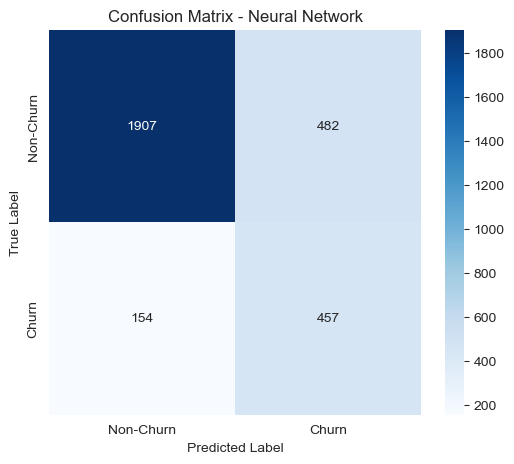

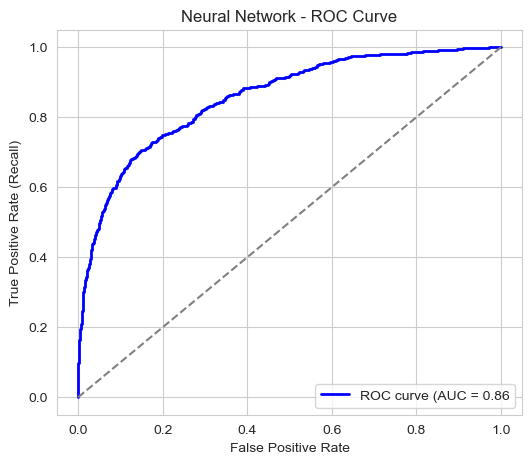

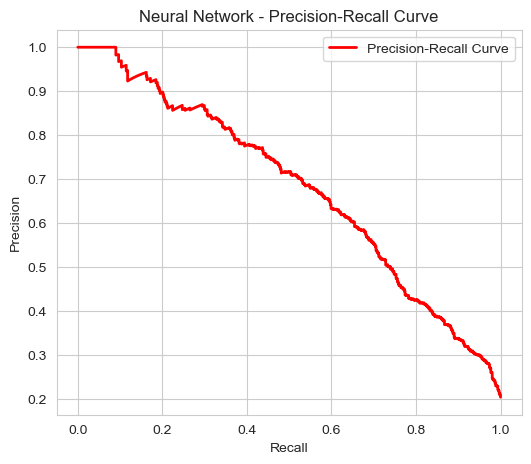

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      2389
           1       0.49      0.75      0.59       611

    accuracy                           0.79      3000
   macro avg       0.71      0.77      0.72      3000
weighted avg       0.84      0.79      0.80      3000


Model results updated and saved to 'model_comparison_results_LogReg_SVM_NN_KNN.csv'


In [6]:
nn_model = GridSearchCV(MLPClassifier(max_iter=3000, solver='adam'), param_grid={'hidden_layer_sizes': [(50,)], 'activation': ['relu', 'tanh'], 'learning_rate_init': [0.0005, 0.001]}, cv=5, scoring='f1')
nn_model.fit(X_train_selected, y_train_resampled)
best_nn = nn_model.best_estimator_
evaluate_model(best_nn, "Neural Network", X_train_selected, y_train_resampled, X_test_selected, y_test)

results_df = pd.DataFrame(results)
results_df.to_csv("model_comparison_results_LogReg_SVM_NN_KNN.csv", index=False)
print("\nModel results updated and saved to 'model_comparison_results_LogReg_SVM_NN_KNN.csv'")

<h2 style="color:black;">7. KNN</h2>

,Dataset,Model,Accuracy,Precision,Recall,F1 Score,F2 Score
0,Train,Logistic Regression,0.717589,0.720682,0.710582,0.715596,0.712579
1,Test,Logistic Regression,0.750000,0.426455,0.659574,0.517995,0.594571
2,Train,SVM,0.801682,0.811280,0.786265,0.798577,0.791144
3,Test,SVM,0.792667,0.494241,0.772504,0.602810,0.694322
4,Train,Neural Network,0.824107,0.837838,0.803784,0.820458,0.810372
5,Test,Neural Network,0.788000,0.486688,0.747954,0.589677,0.675436
6,Train,KNN,0.810792,0.818835,0.798178,0.808375,0.802226
7,Test,KNN,0.744333,0.428440,0.764321,0.549089,0.660724


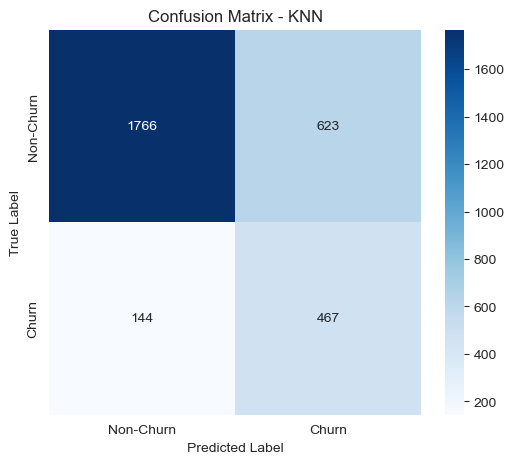

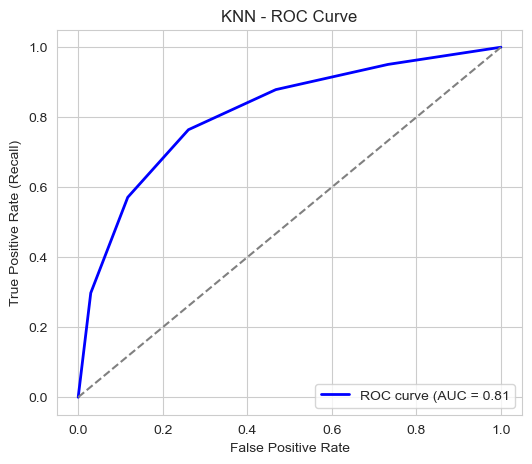

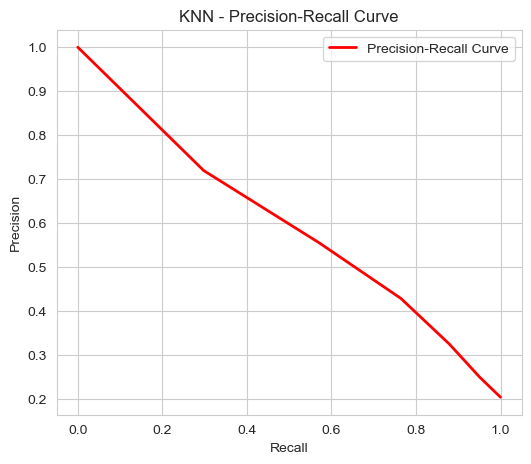

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      2389
           1       0.43      0.76      0.55       611

    accuracy                           0.74      3000
   macro avg       0.68      0.75      0.69      3000
weighted avg       0.82      0.74      0.77      3000


Model results updated and saved to 'model_comparison_results_LogReg_SVM_NN_KNN.csv'


In [7]:
knn_model = GridSearchCV(KNeighborsClassifier(), param_grid={'n_neighbors': [3, 5, 7]}, cv=5, scoring='f1')
knn_model.fit(X_train_selected, y_train_resampled)
best_knn = knn_model.best_estimator_
evaluate_model(best_knn, "KNN", X_train_selected, y_train_resampled, X_test_selected, y_test)

results_df = pd.DataFrame(results)
results_df.to_csv("model_comparison_results_LogReg_SVM_NN_KNN.csv", index=False)
print("\nModel results updated and saved to 'model_comparison_results_LogReg_SVM_NN_KNN.csv'")